# Using a Bandpass Filter
Shateesh Bhugwansing

Attempting to filter for specific frequencies in order to improve classification results.  
  
Ning suggested a bandpass filter of (1,30). I am using a sampling frequency of 61 Hz. 

In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# the  classifiers used by our group
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import os.path as op
from os import listdir

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams.update({'font.size': 12})


#import mne to read EEG data 
import mne 
from mne.decoding import Vectorizer

In [16]:
# Store all filenames in a list 
# using os module (a python thing)

data_dir = "/Volumes/SB/all_eeg_data/eeg_data"
all_runs = [f for f in listdir(data_dir) if op.isfile(op.join(data_dir, f))]

# remove corrupt files 
all_runs.remove('Ex10_Suj26_Run2-epo.fif')
all_runs.remove('Ex10_Suj26_Run4-epo.fif')

# remove files where number of new + scrambled epochs < 10
all_runs.remove('Ex10_Suj19_Run1-epo.fif')
all_runs.remove('Ex10_Suj21_Run1-epo.fif')
all_runs.remove('Ex10_Suj26_Run1-epo.fif')
all_runs.remove('Ex10_Suj26_Run3-epo.fif')

### Testing the filtering function on locally stored data 

In [14]:
#read in the data for the first 4 runs of subject 1, and all runs for subject1
path1 = "/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run1-epo.fif"
path2 = "/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run2-epo.fif"
path3 = "/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run3-epo.fif"
path4 = "/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run4-epo.fif"
path_all = "/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/subject1_all_runs-epo.fif"

run1 = mne.read_epochs(path1, preload=True)
run2 = mne.read_epochs(path2, preload=True)
run3 = mne.read_epochs(path3, preload=True)
run4 = mne.read_epochs(path4, preload=True)
runs_all = mne.read_epochs(path_all, preload=True)

# extract only the event_id's 4-5 for new vs. scrambled 
run1 = run1[(run1.events[:,-1] == 4) | (run1.events[:,-1] == 5)]
run2 = run2[(run2.events[:,-1] == 4) | (run2.events[:,-1] == 5)]
run3 = run3[(run3.events[:,-1] == 4) | (run3.events[:,-1] == 5)]
run4 = run4[(run4.events[:,-1] == 4) | (run4.events[:,-1] == 5)]
runs_all = runs_all[(runs_all.events[:,-1] == 4) | (runs_all.events[:,-1] == 5)]

#store the actual data 
data1 = run1.get_data()
data2 = run2.get_data()
data3 = run3.get_data()
data4 = run4.get_data()
data_all = runs_all.get_data()

#store labels (used as targets in the classifier algorithms)
labels1 = run1.events[:,-1]
labels2 = run2.events[:,-1]
labels3 = run3.events[:,-1]
labels4 = run4.events[:,-1]
labels_all = runs_all.events[:,-1]

Reading /Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading /Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
285 matching events found
Created an SSP operator (subspace dimension = 1)
285 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection it

### Bandpass filter for Beta Waves
Based on the link that Ning sent (http://neurosky.com/2015/05/greek-alphabet-soup-making-sense-of-eeg-bands/), optimal Beta waves are used for memory and problem solving tasks. I'll filter for the frequencies 12-30 HZ. 

In [41]:
data1_filtered = mne.filter.filter_data(data1, 637, 12, 30)

Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected


# All Subjects, All runs: GaussianNB

In [43]:
# Run classification on all files, in a loop


# CLASSIFIER: GaussianNB
scores_nb = []
for i in all_runs:
    epo = mne.epochs.read_epochs(op.join(data_dir, i), preload=True);
    
    # extract just events 4 & 5 from epochs object
    epo = epo[(epo.events[:,-1] == 4) | (epo.events[:,-1] == 5)]
    
    # get data and targets from epo list, use for classification
    data = epo.get_data()
    labels = epo.events[:,-1]
    
    # FILTER DATA USING BANDPASS FILTER FOR BETA WAVES
    data_filtered = mne.filter.filter_data(data, 637, 12, 30)    
    
    # prep classifier, prediction array, CV
    clf = make_pipeline(Vectorizer(),
                       StandardScaler(), 
                       GaussianNB())
    
    X_train, X_test, y_train, y_test = train_test_split(data_filtered, labels, test_size = 0.2, random_state = 42)
    clf.fit(X_train, y_train)
    scores_nb.append(clf.score(X_test, y_test))
    
print("loop is done. \n", len(scores_nb))

Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj10_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
294 matching events found
Created an SSP operator (subspace dimension = 1)
294 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj10_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    14

l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj13_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
304 matching events found
Created an SSP operator (subspace dimension = 1)
304 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj13_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 p

Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj15_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
278 matching events found
Created an SSP operator (subspace dimension = 1)
278 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz

297 matching events found
Created an SSP operator (subspace dimension = 1)
297 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj18_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
291 matching events found
Created an SSP operator (subspace dimension = 1)
291 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defa

        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
303 matching events found
Created an SSP operator (subspace dimension = 1)
303 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj20_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
303 matching events found
Created an SSP operator (subspace dimension = 1

Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj23_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
305 matching events found
Created an SSP operator (subspace dimension = 1)
305 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj23_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the

l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj27_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
302 matching events found
Created an SSP operator (subspace dimension = 1)
302 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj27_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 p

Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj3_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
294 matching events found
Created an SSP operator (subspace dimension = 1)
294 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz


Created an SSP operator (subspace dimension = 1)
221 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj6_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
221 matching events found
Created an SSP operator (subspace dimension = 1)
221 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 b

    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
293 matching events found
Created an SSP operator (subspace dimension = 1)
293 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj8_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
285 matching events found
Created an SSP operator (subspace dimension = 1)
285 matching events found
Created an SSP oper

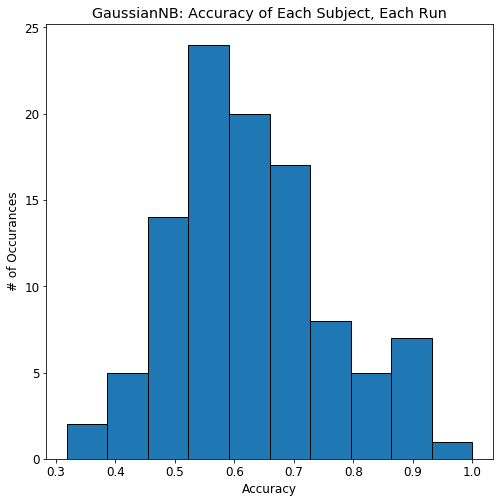

In [44]:
plt.title('GaussianNB: Accuracy of Each Subject, Each Run')
plt.xlabel('Accuracy')
plt.ylabel('# of Occurances')
plt.rcParams["patch.force_edgecolor"] = True
plt.hist(scores_nb, bins=10);

In [45]:
print "GaussianNB: Average score, all runs: ", np.mean(scores_nb)

GaussianNB: Average score, all runs:  0.628394223040582


### All Subjects, All runs: Logistic Regression 

In [47]:
# Run classification on all files, in a loop


# CLASSIFIER: Logistic Regression
scores_lr = []
for i in all_runs:
    epo = mne.epochs.read_epochs(op.join(data_dir, i), preload=True);
    
    # extract just events 4 & 5 from epochs object
    epo = epo[(epo.events[:,-1] == 4) | (epo.events[:,-1] == 5)]
    
    # get data and targets from epo list, use for classification
    data = epo.get_data()
    labels = epo.events[:,-1]
    
    # FILTER DATA USING BANDPASS FILTER FOR BETA WAVES
    data_filtered = mne.filter.filter_data(data, 637, 12, 30)    
    
    # prep classifier, prediction array, CV
    clf = make_pipeline(Vectorizer(),
                       StandardScaler(), 
                       LogisticRegression(penalty='l2'))
    
    X_train, X_test, y_train, y_test = train_test_split(data_filtered, labels, test_size = 0.2, random_state = 42)
    clf.fit(X_train, y_train)
    scores_lr.append(clf.score(X_test, y_test))
    
print("loop is done. \n", len(scores_lr))

Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj10_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
294 matching events found
Created an SSP operator (subspace dimension = 1)
294 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj10_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    14

l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj13_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
304 matching events found
Created an SSP operator (subspace dimension = 1)
304 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj13_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 p

Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj15_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
278 matching events found
Created an SSP operator (subspace dimension = 1)
278 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz

297 matching events found
Created an SSP operator (subspace dimension = 1)
297 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj18_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
291 matching events found
Created an SSP operator (subspace dimension = 1)
291 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defa

        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
303 matching events found
Created an SSP operator (subspace dimension = 1)
303 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj20_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
303 matching events found
Created an SSP operator (subspace dimension = 1

Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj23_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
305 matching events found
Created an SSP operator (subspace dimension = 1)
305 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj23_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the

l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj27_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
302 matching events found
Created an SSP operator (subspace dimension = 1)
302 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj27_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 p

Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj3_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
294 matching events found
Created an SSP operator (subspace dimension = 1)
294 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz


Created an SSP operator (subspace dimension = 1)
221 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj6_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
221 matching events found
Created an SSP operator (subspace dimension = 1)
221 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 b

    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
293 matching events found
Created an SSP operator (subspace dimension = 1)
293 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up band-pass filter from 12 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1401 samples (2.199 sec) selected
Reading /Volumes/SB/all_eeg_data/eeg_data/Ex10_Suj8_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
285 matching events found
Created an SSP operator (subspace dimension = 1)
285 matching events found
Created an SSP oper

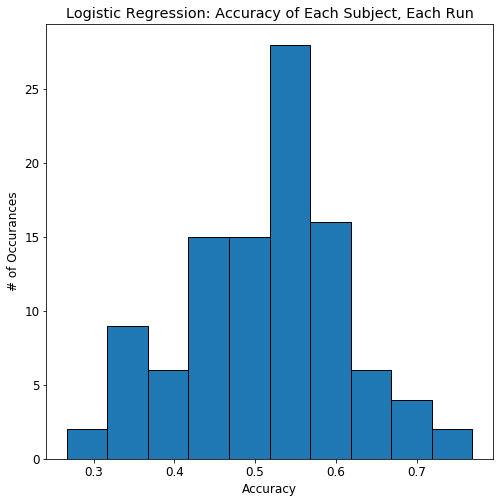

In [48]:
plt.title('Logistic Regression: Accuracy of Each Subject, Each Run')
plt.xlabel('Accuracy')
plt.ylabel('# of Occurances')
plt.rcParams["patch.force_edgecolor"] = True
plt.hist(scores_lr, bins=10);

In [49]:
print "Logistic Regression: Average score, all runs: ", np.mean(scores_lr)

Logistic Regression: Average score, all runs:  0.5159226485461615


### All Subjects, All runs: KNN

### All Subjects, All runs: Linear Discriminant Analysis 